In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
class Firm_N:
    def __init__(self, mc, price_floor, price_cap, learning_rate=0.85, discount_factor=0.9):
        self.mc = mc
        self.price_floor = price_floor
        self.price_cap = price_cap
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.q_table = {}

    def get_state(self, prices):
        return tuple(round(p, 2) for p in prices)

    def get_action(self, state):
        if state not in self.q_table:
            self.q_table[state] = {0: 0, 1: 0, 2: 0}
        if np.random.rand() < 0.1: 
            return np.random.choice([0, 1, 2])
        else:
            return max(self.q_table[state], key=self.q_table[state].get)

    def update_q_value(self, state, action, reward, next_state):
        if next_state not in self.q_table:
            self.q_table[next_state] = {0: 0, 1: 0, 2: 0}
        best_next_action = max(self.q_table[next_state], key=self.q_table[next_state].get)
        
        
        last_price_effect = 0.5 * (next_state[1] - self.mc)
        scaled_reward = reward + last_price_effect

        self.q_table[state][action] += self.learning_rate * (
            scaled_reward
            + self.discount_factor * self.q_table[next_state][best_next_action]
            - self.q_table[state][action]
        )

    def calculate_profit(self, price, competitor_prices):
        quantity_sold = 100 - price 
        return (price - self.mc) * max(quantity_sold, 0)


def simulate_bertrand_rl_n(n_players = 2, max_iterations=500000, price_floor=10, price_cap=55, start_prices=10):
     
    firms = [
        Firm_N(mc=10, price_floor=price_floor, price_cap=price_cap)
        for _ in range(n_players)
    ]

    
    if isinstance(start_prices, (int, float)):
        prices = [start_prices] * n_players
    elif isinstance(start_prices, list):
        if len(start_prices) != n_players:
            raise ValueError("Length of start_prices must match n_players")
        prices = start_prices
    else:
        raise ValueError("start_prices must be an int, float, or list of length n_players")

    price_histories = [[p] for p in prices]
    rewards = [[] for _ in range(n_players)]

    for i in range(max_iterations):
        states = [firm.get_state(prices) for firm in firms]
        actions = [firm.get_action(state) for firm, state in zip(firms, states)]

        
        new_prices = []
        for j, (firm, action) in enumerate(zip(firms, actions)):
            if j > 0 and prices[j] < prices[j - 1]:
                new_price = min(prices[j - 1], 55) 
            else:
                if action == 0: 
                    new_price = max(prices[j] - 1, price_floor)
                elif action == 2:  
                    new_price = min(prices[j] + 1, price_cap)
                else:
                    new_price = prices[j]
            new_prices.append(new_price)
        
        profits = [
            firm.calculate_profit(new_prices[j], [p for k, p in enumerate(new_prices) if k != j])
            for j, firm in enumerate(firms)
        ]

        for j, firm in enumerate(firms):
            next_state = firm.get_state(new_prices)
            firm.update_q_value(states[j], actions[j], profits[j], next_state)

        for j in range(n_players):
            price_histories[j].append(new_prices[j])
            rewards[j].append(profits[j])

        prices = new_prices
        if max(new_prices) == 55:
            break

    return price_histories, rewards

In [3]:
priceA, _ = simulate_bertrand_rl_n(5, 10000000, 10, 55, 10)
priceB, _ = simulate_bertrand_rl_n(3, 10000000, 10, 55, 10)

In [ ]:

priceAonly = priceA[0]
priceBonly = priceB[0]

moving_avg_5 = pd.Series(priceAonly).rolling(window=1000).mean()
moving_avg_3 = pd.Series(priceBonly).rolling(window=1000).mean()

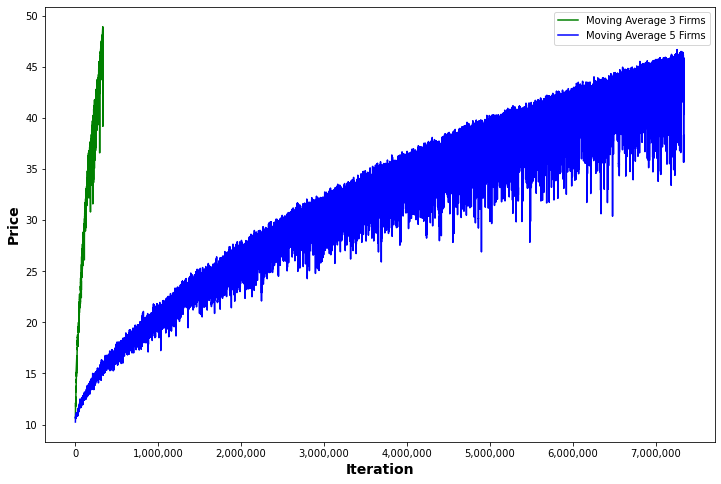

In [10]:

fig, ax = plt.subplots(figsize=(12, 8)) 


ax.plot(moving_avg_3, '-', label="Moving Average 3 Firms", color="green")
ax.plot(moving_avg_5, '-', label="Moving Average 5 Firms", color="blue")


ax.set_xlabel("Iteration", fontsize=14, fontweight='bold')
ax.set_ylabel("Price", fontsize=14, fontweight='bold')
ax.legend()


ax.grid(False)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.savefig("combined_convergence.png", format="png", bbox_inches="tight")
plt.show()

In [9]:
print(len(priceB[0]))
print(len(priceA[0]))

335839
7343578
